In [1]:
# This is a guide to 
%matplotlib notebook
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.ion()

In [6]:
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles


outline = gpd.read_file('Iceland/ISL_adm0.shp').to_crs(32626)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

In [7]:
roads = gpd.read_file('Iceland/roads.shp').to_crs(32626)
rivers = gpd.read_file('Iceland/waterways.shp').to_crs(32626)
points = gpd.read_file('Iceland/points.shp').to_crs(32626)
counties = gpd.read_file ('Iceland/ISL_adm1.shp').to_crs(32626)
population = gpd.read_file('Iceland/population.shp').to_crs(32626)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

<IPython.core.display.Javascript object>


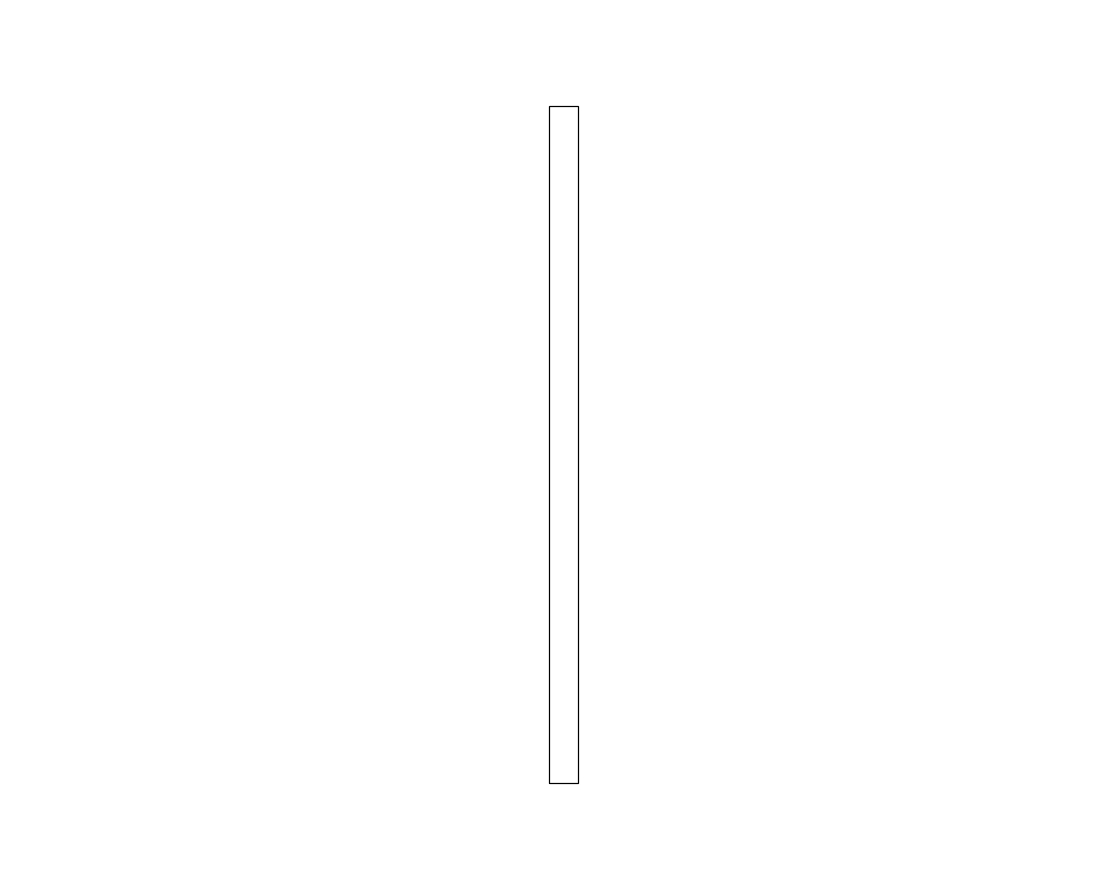

<IPython.core.display.Javascript object>


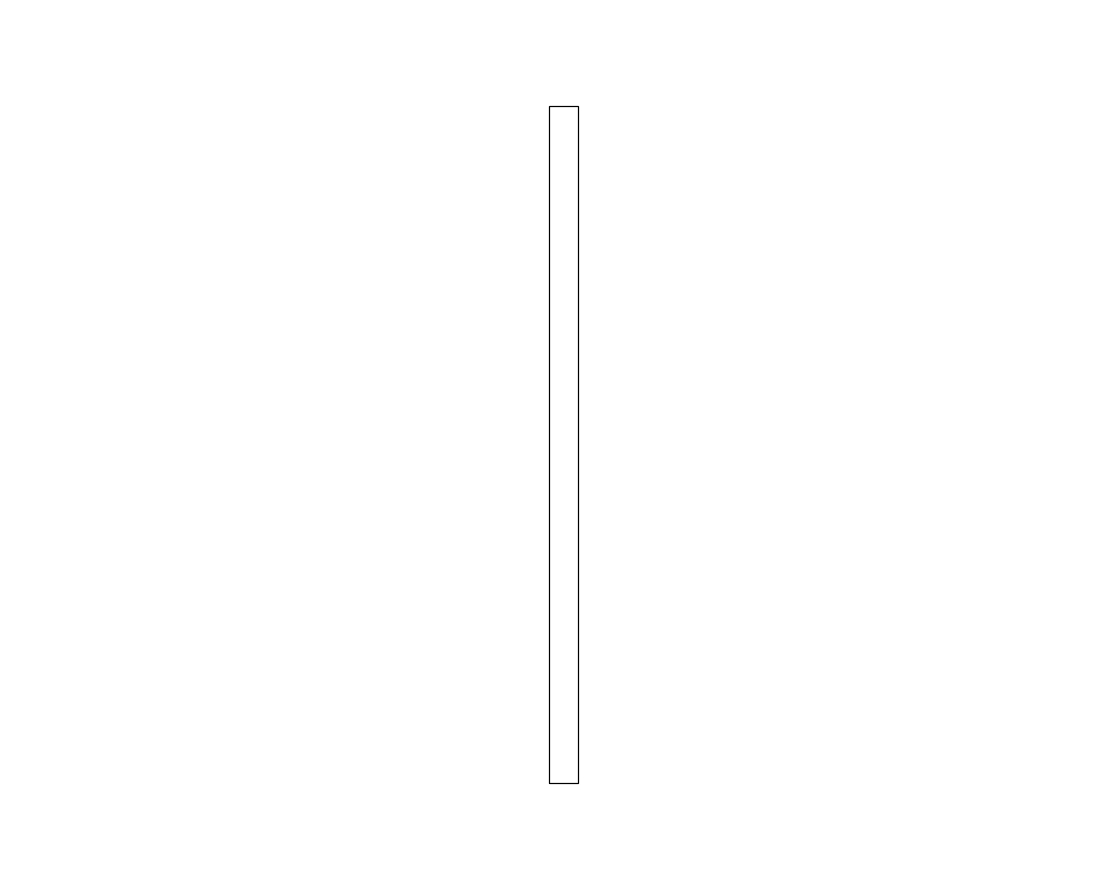

In [8]:
myFig = plt.figure(figsize=(10,8))

myCRS = ccrs.UTM(26)  

ax = plt.axes(projection=ccrs.UTM(26))

myFig

In [9]:
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature)

ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) 

myFig

NameError: name 'outline' is not defined

In [10]:
num_counties = len(counties.NAME_1.unique())
print('Number of unique features: {}'.format(num_counties))

NameError: name 'counties' is not defined

In [11]:
df = pd.read_csv('Iceland\ISL_adm1.csv')
df.head()
df

,OBJECTID,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1
0,1,104,ISL,Iceland,1,Austurland,Landsvæði,Region,NaN,Eastland
1,2,104,ISL,Iceland,2,Hálshreppur,Landsvæði,Region,NaN,Norðurland eystra|Northland East
2,3,104,ISL,Iceland,3,Höfuðborgarsvæði,Landsvæði,Region,NaN,Capital|Reykjavik and Reykjane
3,4,104,ISL,Iceland,4,Norðurland vestra,Landsvæði,Region,NaN,Northland West
4,5,104,ISL,Iceland,5,Suðurland,Landsvæði,Region,NaN,Southland|South
5,6,104,ISL,Iceland,6,Suðurnes,Kaupstadir,Independent Town,NaN,Southern Peninsula
6,7,104,ISL,Iceland,7,Vestfirðir,Landsvæði,Region,NaN,Western Fjords|Western Peninsula
7,8,104,ISL,Iceland,8,Vesturland,Landsvæði,Region,NaN,Westland|West


In [12]:
county_colors = ['g','mediumseagreen','mediumaquamarine','mediumturquoise','slateblue','c','maroon','darkolivegreen']

county_names = list(counties.NAME_1.unique())
county_names.sort()

for i, name in enumerate(county_names):
    feat = ShapelyFeature(counties['geometry'][counties['NAME_1'] == name], myCRS, 
                          edgecolor='k',
                          facecolor=county_colors[i],
                          linewidth=1,
                          alpha=0.25)
    ax.add_feature(feat)
    
myFig


NameError: name 'counties' is not defined

In [13]:
river_feat = ShapelyFeature(rivers['geometry'], myCRS,
                            edgecolor='green',
                            linewidth=0.2)
ax.add_feature(river_feat)
roads_feat= ShapelyFeature(roads['geometry'], myCRS,
                            edgecolor='red',
                             linewidth=0.2)

ax.add_feature(roads_feat)

myFig

NameError: name 'rivers' is not defined

In [ ]:
# generate a list of handles for the county datasets
county_handles = generate_handles(counties.NAME_1.unique(), county_colors, alpha=0.25)

# note: if you change the color you use to display rivers, you'll want to change it here, too
river_handle = [mlines.Line2D([], [], color='royalblue')]

roads_handle = [mlines.Line2D([],[], color='red')]

# update county_names to take it out of uppercase text
nice_names = [name.title() for name in county_names]

# ax.legend() takes a list of handles and a list of labels corresponding to the objects you want to add to the legend
handles = county_handles + river_handle + roads_handle
labels = nice_names + ['Rivers', 'Roads']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=10, 
                 fontsize=8, loc='upper left', frameon=True, framealpha=1)
ax.set(title='Icelands Roads and Municipalities')

myFig

In [ ]:
df = gpd.read_file('Iceland\waterways.shp').to_crs(32626)
df.head()
df

In [ ]:
counties = gpd.read_file ('Iceland/ISL_adm1.shp').to_crs(32626)



In [ ]:
#check that both datatsets are going to work in a join with the CRS
rivers.crs
counties.crs

In [ ]:
#As its a large file, want to focus on just one element of interest type. In this case attractions!
rivers[rivers['type'] == 'river']

In [ ]:
for i, row in rivers.iterrows(): 
    rivers.loc[i, 'Length'] = row['geometry'].length 
    
print(rivers.head()) 

In [ ]:
sum_rivers = rivers['Length'].sum()
sum_mainrivers = rivers[rivers['type'] == 'river']['Length'].sum()
print('{:.2f} total m of rivers'.format(sum_rivers))
print('{:.2f} total m of mainrivers'.format(sum_mainrivers))


In [ ]:
rivers.groupby(['type'])['Length'].sum() / 1000 

In [ ]:
join = gpd.sjoin(counties, rivers, how='inner', lsuffix='left', rsuffix='right')
join # show the joined table

In [ ]:
join_total = join['Length'].sum()
print(join.groupby(['NAME_1', 'type'])['Length'].sum() / 1000) 

print(sum_rivers)
print(join_total)

In [ ]:
clipped = [] 
for county in counties['NAME_1'].unique():
    tmp_clip = gpd.clip(rivers, counties[counties['NAME_1'] == county]) 
    for i, row in tmp_clip.iterrows():
        tmp_clip.loc[i, 'type'] = row['geometry'].length 
        tmp_clip.loc[i, 'NAME_1'] = county 
    clipped.append(tmp_clip) 


clipped_gdf = gpd.GeoDataFrame(pd.concat(clipped))
clip_total = clipped_gdf['Length'].sum()


print(clip_total) 

In [ ]:
#clipped_gdf[clipped_gdf['type'] == 'river'].groupby('NAME_1').sum()
#df# need to write summary on clipped data ... export chart?...
clipped_gdf.groupby('type')['river'].sum()

In [ ]:
#second section--------------------------------------------------------------------

In [ ]:
counties.crs

In [ ]:
plt.figure(1)
myFig2 = plt.figure(figsize=(9, 9)) 

myCRS = ccrs.UTM(26)  

ax = plt.axes(projection=ccrs.Mercator()) 

myFig2

In [ ]:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

In [ ]:
population = gpd.read_file('Iceland/population.shp')
print(population)

In [ ]:
population_plot=population.plot(column='Population', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='r')

population_plot = population.plot(column='Population', ax=ax, vmin=300, vmax=300000, cmap='viridis',
                      legend=True, cax=cax, legend_kwds={'label': 'Resident Population'})

population_outlines = ShapelyFeature(population['geometry'], myCRS, edgecolor='r', facecolor='none')

ax.add_feature(population_outlines)
population_handles = generate_handles([''], ['none'], edge='r')

ax.set(title='Icelands Resident population')
ax.legend(population_handles, ['County Boundaries'], fontsize=12, loc='lower center', framealpha=1)

myFig2

In [ ]:


#----------------------------------------------------------------------------------------